In [1]:
import jax.numpy as np
import numpy as onp
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

from jax import grad, jacobian, random, lax, vmap
key = random.PRNGKey(0)

from functools import partial
from collections import namedtuple

def softmax_2actions(a=[2.5,-2.5], b=[0, 1]):
    """ 2 action softmax """
    a = np.array(a)
    da = np.array([1, -1])*(a[0]-a[1])
    b = np.array(b)
    def pi(x):
        x = a*x + b    # affine shift 
        x -= np.max(x) # numerical stability, since pi(x) = pi(x+c)
        X = np.sum(np.exp(x))
        return np.exp(x)/X

    def dpi(x):
        p = pi(x)
        return (1 - p)*p*da

    def ddpi(x):
        return (1 - 2*pi(x))*dpi(x)*da

    return pi, dpi, ddpi

def bimatrix_2player_2actions(A, B, 
                              softmax_temperature=2.5,
                              softmax_shift=0.5,
                              reg_l2_self=0.2,
                              reg_l2_other=0.0,
                              reg_ent_self=0,
                              reg_ent_other=0):
  
    # Softmax policies for 2 discrete actions
    pi, dpi, ddpi = \
        softmax_2actions([softmax_temperature, -softmax_temperature], \
                         softmax_shift)

    # Atoms
    def ent(x): return np.sum(np.log(pi(x))*pi(x))
    def dent(x): return dpi(x)@np.log(pi(x))
    def l2(x): return x**2/2

    # Regularization
    def reg(xi, xj):
        return reg_ent_self*ent(xi) + reg_l2_self*l2(xi) \
             + reg_ent_other*ent(xj) + reg_l2_other*l2(xj)

    def dreg(xi, xj):
        return (reg_ent_self*dent(xi) + reg_l2_self*xi, \
                reg_ent_other*dent(xj) + reg_l2_other*xj)

    # Costs
    def f1(x1, x2): return pi(x1)@A@pi(x2) + reg(x1, x2)
    def f2(x1, x2): return pi(x1)@B@pi(x2) + reg(x2, x1)

    # Gradients
    def D1f1(x1, x2): return dpi(x1)@A@pi(x2) + dreg(x1, x2)[0]
    def D2f1(x1, x2): return pi(x1)@A@dpi(x2) + dreg(x1, x2)[1]
    def D1f2(x1, x2): return dpi(x1)@B@pi(x2) + dreg(x2, x1)[1]
    def D2f2(x1, x2): return pi(x1)@B@dpi(x2) + dreg(x2, x1)[0]

    # Jacobian
    def D11f1(x1, x2): return ddpi(x1)@A@pi(x2) + reg_l2_self
    def D22f2(x1, x2): return pi(x1)@B@ddpi(x2) + reg_l2_self
    def D12f1(x1, x2): return dpi(x1)@A@dpi(x2) 
    def D21f2(x1, x2): return dpi(x1)@B@dpi(x2)

    # Adjoints
    def D21f1(x1, x2): return dpi(x1)@A@dpi(x2) 
    def D12f2(x1, x2): return dpi(x1)@B@dpi(x2)

    # Game Dynamics
    def simgrad(x1, x2): return np.hstack([D1f1(x1, x2), D2f2(x1, x2)])
    def stackgrad(x1, x2): return np.hstack([D1f1(x1, x2) - D12f2(x1, x2)/D22f2(x1, x2)*D2f1(x1, x2), \
                                             D2f2(x1, x2)])
    def impconj(x1, x2): return np.hstack([D1f1(x1, x2) - D12f2(x1, x2)/D22f2(x1, x2)*D2f1(x1, x2), \
                                           D2f2(x1, x2) - D21f1(x1, x2)/D11f1(x1, x2)*D1f2(x1, x2)])

    assert reg_ent_self == 0 or reg_ent_other == 0, \
           "Not Implemented: Second order entropy deriatives"

    return (f1, f2), \
           (D1f1, D2f1, D1f2, D2f2), \
           (D11f1, D12f1, D21f2, D22f2), \
           (simgrad, stackgrad, impconj)# gradconj, fastconj)

def test_gradients():
    """ Runs test on gradients """
    key = random.PRNGKey(0)
    x = random.normal(key, (2,))
    f1, f2 = costs
    D1f1, D2f1, D1f2, D2f2 = gradients
    simgrad, *_ = updates
    grad(f1, (0,1))(*x), (D1f1(*x), D2f1(*x)), None, \
    grad(f2, (0,1))(*x), (D1f2(*x), D2f2(*x)), None,\

    jacobian(simgrad, (0,1))(*x),\
    [j(*x) for j in jacobians]
    assert False, "Missing: add assert cases"

/Users/ben/anaconda3/envs/2020fiez-icml/lib/python3.6/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
def scan(update, x0, num_iter):
    def step(x,i):
        g = update(*x)
        return x - g, x
    return lax.scan(step, x0, np.arange(int(num_iter)))[1]
  
def initial_grid(key, xlim, ylim, sampling_mode, N):
    """ Returns a grid or random samples. """
    keys = random.split(key, 2)

    if sampling_mode is 'grid':
        N = int(np.sqrt(N))
        c = (xlim[1]-xlim[0])/2/N
        d = (ylim[1]-ylim[0])/2/N
        xlim = np.linspace(xlim[0]+c,xlim[1]-c,N)
        ylim = np.linspace(ylim[0]+d,ylim[1]-d,N)
        xlim, ylim = np.meshgrid(xlim, ylim)
        xlim, ylim = xlim.ravel(), ylim.ravel()
    elif sampling_mode is 'random':
        xlim, ylim = [random.uniform(keys[i], (N,), minval=lim[0], maxval=lim[1]) 
                      for i,lim in enumerate([xlim, ylim])]

    return np.vstack([xlim, ylim]).T

def plot_trajectories(ax, x, xlim, ylim, **kwargs):
    ax.plot(*x.T, '.', **kwargs)
#     for _ in x:
#         ax.plot(*_[-1], 'or')
    ax.set_aspect('equal')
    ax.grid()
    
def plot_points(ax, x, settings, loc=-1):
    for path, config in zip(x, settings):
        if config is not None:
            ax.plot(*path[loc], 'o', **config)
    

def plot_stream(ax, update, xlim, ylim, N, **kwargs):
    grid = onp.mgrid[ylim[0]:ylim[1]:N*1j, xlim[0]:xlim[1]:N*1j]
    Y, X = grid
    grid = np.reshape(np.vstack([X, Y]), (2,N*N))
    U, V = -vmap(update, (0,0))(*grid).T
    U, V = U.reshape(N,N), V.reshape(N,N)

    ax.streamplot(X, Y, U, V, **kwargs)
    ax.set_aspect('equal')
    ax.set(xlim=xlim, ylim=ylim)

def plot_gradnorm(ax, function, xlim, ylim, N=1024, vmin=None, vmax=None, cmap=plt.cm.Greys):
    grid = initial_grid(key, sampling_mode='grid', N=N**2, xlim=xlim, ylim=ylim)
    xx, yy = grid.T
    cc = np.linalg.norm(vmap(function)(xx, yy),axis=1).reshape(N,N)
    xx = xx.reshape(N,N)
    yy = yy.reshape(N,N)
    print('min', cc.min())
    print('max', cc.max())
    vmin = cc.min() if vmin is None else vmin
    vmax = cc.max() if vmax is None else vmax
    norm = matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax)
    return ax.pcolormesh(xx,yy,cc, norm=norm, cmap=cmap)

In [3]:
""" Game settings """
# A,B = np.array([[5,2],[7,5]]), np.array([[-3,2],[7,1]])
A,B = np.array([[1,0],[0,1]]), np.array([[1/2,1],[1,1/2]])
config_softmax = dict(softmax_temperature=2.5, softmax_shift=[0,0])
config_regularization = dict(reg_l2_self=0.1, reg_l2_other=0, reg_ent_self=0, reg_ent_other=0)
print("Finite Game: \nA=",A,"\nB=",B)

""" Game costs and differential forms """
costs, gradients, jacobians, updates = bimatrix_2player_2actions(A, B, **config_softmax, **config_regularization)
simgrad, stackgrad, impconj = updates


Finite Game: 
A= [[1 0]
 [0 1]] 
B= [[0.5 1. ]
 [1.  0.5]]


min 0.000104185165
max 0.026096687


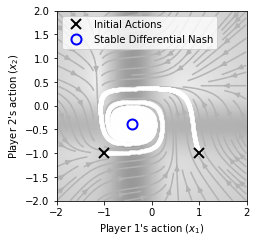

x0 :  [-1. -1.]
xast :  [-0.42477897 -0.38634542]
player 1 policy:  [0.46906585 0.53093415]
player 2 policy:  [0.5170616  0.48293838]

x0 :  [ 1. -1.]
xast :  [-0.4247944  -0.38633958]
player 1 policy:  [0.46904665 0.53095335]
player 2 policy:  [0.5170689  0.48293108]

min 0.00028683094
max 0.1331861


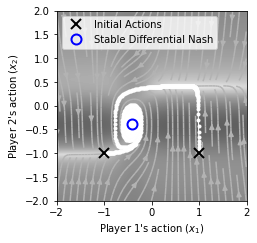

x0 :  [-1. -1.]
xast :  [-0.42477977 -0.38629845]
player 1 policy:  [0.46906483 0.53093517]
player 2 policy:  [0.51712024 0.48287973]

x0 :  [ 1. -1.]
xast :  [-0.42478907 -0.38642162]
player 1 policy:  [0.4690533  0.53094673]
player 2 policy:  [0.51696646 0.48303357]

min 7.064974e-05
max 497.5333


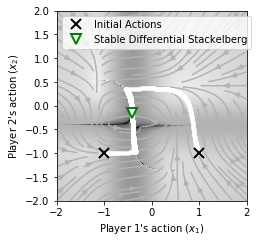

x0 :  [-1. -1.]
xast :  [-0.41443014 -0.16065857]
player 1 policy:  [0.48197016 0.51802987]
player 2 policy:  [0.76793844 0.23206152]

x0 :  [ 1. -1.]
xast :  [-0.41443062 -0.16065106]
player 1 policy:  [0.48196954 0.51803046]
player 2 policy:  [0.76794523 0.23205484]

min 0.00058262853
max 497.5333


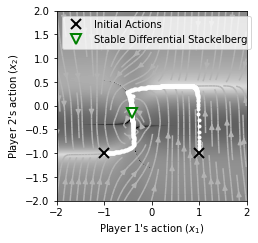

x0 :  [-1. -1.]
xast :  [-0.4144303  -0.16065636]
player 1 policy:  [0.48196995 0.51803005]
player 2 policy:  [0.7679404  0.23205952]

x0 :  [ 1. -1.]
xast :  [-0.41443047 -0.16065374]
player 1 policy:  [0.4819697 0.5180303]
player 2 policy:  [0.76794285 0.2320572 ]

min 0.0001348299
max 0.025321368


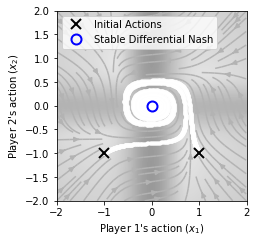

x0 :  [-1. -1.]
xast :  [ 1.38767045e-05 -1.35147184e-05]
player 1 policy:  [0.50001734 0.49998266]
player 2 policy:  [0.4999831 0.5000169]

x0 :  [ 1. -1.]
xast :  [2.2083887e-05 5.4775105e-06]
player 1 policy:  [0.5000276 0.4999724]
player 2 policy:  [0.50000685 0.49999318]

min 0.0005850116
max 0.12517987


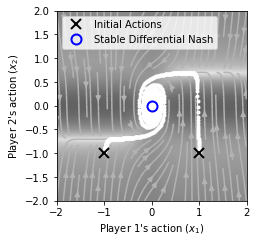

x0 :  [-1. -1.]
xast :  [ 1.0862846e-09 -9.6308539e-17]
player 1 policy:  [0.5 0.5]
player 2 policy:  [0.5 0.5]

x0 :  [ 1. -1.]
xast :  [-9.839600e-10 -6.234266e-17]
player 1 policy:  [0.5 0.5]
player 2 policy:  [0.5 0.5]

min 0.00014607527
max 176.26785


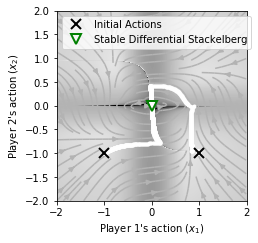

x0 :  [-1. -1.]
xast :  [-1.0368702e-13 -7.5052161e-14]
player 1 policy:  [0.5 0.5]
player 2 policy:  [0.5 0.5]

x0 :  [ 1. -1.]
xast :  [-9.5883398e-14  1.1600997e-13]
player 1 policy:  [0.5 0.5]
player 2 policy:  [0.5 0.5]

min 0.0011633678
max 176.26785


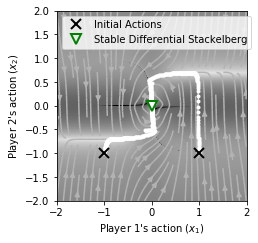

x0 :  [-1. -1.]
xast :  [1.4950067e-17 1.1587567e-37]
player 1 policy:  [0.5 0.5]
player 2 policy:  [0.5 0.5]

x0 :  [ 1. -1.]
xast :  [-1.9052775e-17  1.1665496e-37]
player 1 policy:  [0.5 0.5]
player 2 policy:  [0.5 0.5]



In [8]:
""" Game Configurations """
key = random.PRNGKey(0)
config_softmax1 = dict(softmax_temperature=2.5, softmax_shift=[1,-1])
config_softmax2 = dict(softmax_temperature=2.5, softmax_shift=[0,0])
config_fig = dict(figsize=(3.5,3.5))
config_grid = dict(xlim=[-2,2], ylim=[-2,2])
config_lims = dict(xlim=[-2, 2], ylim=[-2,2])
config_sampling = dict(sampling_mode='grid', N=2**2)
config_stream = dict(N=32, color=(.7,.7,.7))
config_gradnorm = dict(N=1024, vmin=.0005, vmax=1.5)
config_traj = dict(color='white', ls='-', lw=1)
config_nash = dict(marker='o', label='Stable Differential Nash', ms=10, markeredgewidth=2, color='blue', markerfacecolor='none')
config_stack = dict(marker='v', label='Stable Differential Stackelberg', ms=10, markeredgewidth=2, color='green', markerfacecolor='none')
config_start = dict(marker='x', color='black', ms=10, markeredgewidth=2)
config_legend = dict(loc='upper left')
config_axes = dict(xlabel='Player 1\'s action ($x_1$)', \
                   ylabel='Player 2\'s action ($x_2$)')
config_point = dict(marker='o', label='critical point', color='r')

""" Run settings """
num_iter = 1e4
gamma = 2e-2
order = 1.5
n_frames = 2
test_case = False

updates = [simgrad, stackgrad]
update_names = ["Nash Learning", "Stackelberg Learning"]
grid = initial_grid(key, **config_grid, **config_sampling)
grid = np.array([[-1.,-1],[1,-1]])

""" Prelimiaries """
ratios = np.array([[1.,1.],
                   [1.,10.]])
# stationaries = [[None, config_nash, None, None]]
# stationaries += [[None, config_nash, None, None]]
# stationaries += [[None, config_nash, config_stack, None]]
# stationaries += [[None, config_nash, config_stack, None]]
stationaries = [[config_point]*len(grid)]*len(ratios)*len(updates)
stationaries = [[config_nash, None],\
                [config_nash, None],\
                [config_stack, None],\
                [config_stack, None] ]
starts = [dict(label='Initial Actions', **config_start),\
         config_start, config_start, config_start]

if test_case:
    updates = [stackgrad]
    update_names = ["stackgrad"]
    stationaries = [[None, config_nash, None, None]]
    ratios = np.array([[1,10.]])
    
assert len(ratios) * len(updates) == len(stationaries), \
    "Missing characterization of stationary points"

""" Run """
count = -1
for config_softmax in [config_softmax1, config_softmax2]:
    costs, gradients, jacobians, updates = bimatrix_2player_2actions(A, B, **config_softmax, **config_regularization)
    simgrad, stackgrad, impconj = updates
    for update, update_name in zip(updates, update_names):
        for i,ratio in enumerate(ratios):
            count += 1
            gamma1, gamma2 = ratio*gamma

            Gamma = np.array([gamma1, gamma2])
            update_timescale = lambda *x: Gamma*update(*x)

            fig, ax = plt.subplots(nrows=1, ncols=1, **config_fig)

            """ Plot graident descent """
            x = vmap(partial(scan, update_timescale), (0, None))(grid, num_iter)
            plot_trajectories(ax, x, **config_grid, **config_traj)
            plot_points(ax, x, starts, loc=0)
            plot_points(ax, x, stationaries[count % len(stationaries)], loc=-1)
#             ax.set_title('Discrete time update')

            plot_stream(ax, update_timescale, **config_lims, **config_stream)
            plot_gradnorm(ax, update_timescale, **config_lims, **config_gradnorm)
#             ax.set_title(r'{} {}'.format(update_name, '(w/ Timescale Separation)' if Gamma[0]!=Gamma[1] else ''))

            ax.set(**config_axes)
            ax.legend(**config_legend)
            plt.savefig("figs/bimatrix_{}_{}_{}.png".format(update_name.replace(" ","_"), i, config_softmax['softmax_shift'][0]), bbox_inches='tight')
            plt.show()

            pi, dpi, ddpi = softmax_2actions(a=np.array([1,-1])*config_softmax['softmax_temperature'],\
                                             b=config_softmax['softmax_shift'])
            for _x in x:
                print('x0 : ',_x[0])
                xast = _x[-1]
                print('xast : ', xast)
                print('player 1 policy: ', pi(xast[0]))
                print('player 2 policy: ', pi(xast[1]))
                #print("Jacobian (stackgrad,autodiff):")
                #print(np.array(jacobian(stackgrad, (0,1))(*xast)).T)
                #print('omegas(x): ', stackgrad(*xast))
                #print(np.array(jacobian(update_timescale, (0,1))(*xast)).T)
                print()

In [5]:
# !convert -delay 40 -loop 0 figs/stackgrad_gif_*.png figs/stackgrad.gif

In [6]:
# for param in [.1,1,2]:
#     print(param)
#     """ Game settings """
#     A,B = -np.array([[1,0],[0,1]]), -np.array([[1/2,1],[1,1/2]])
#     config_softmax = dict(softmax_temperature=param, softmax_shift=[-1,1])
#     config_regularization = dict(reg_l2_self=2/5, reg_l2_other=0, reg_ent_self=0, reg_ent_other=0)
#     print("Finite Game: \nA=",A,"\nB=",B)

#     """ Game costs and differential forms """
#     costs, gradients, jacobians, updates = bimatrix_2player_2actions(A, B, **config_softmax, **config_regularization)
#     simgrad, stackgrad, impconj = updates

#     fig, ax = plt.subplots()
#     plot_gradnorm(ax, lambda *x: np.array([1,10])*stackgrad(*x), **config_grid)
#     plt.show()
    
#     fig, ax = plt.subplots()
#     plot_gradnorm(ax, lambda *x: np.array([1,10])*simgrad(*x), **config_grid)
#     plt.show()